In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

# CUSTOMERS = [(0, 0), (1, 5), (2, 2), (3, 8), (5, 5), (6, 1), (8, 3)]
np.random.seed(42)

SIZE = "MEDIUM" # SMALL, MEDIUM, LARGE

if(SIZE=="SMALL"):
  CUSTOMER_COUNT = np.random.randint(10, 20)
  VEHICLES = np.random.randint(2, 10)
elif(SIZE=="MEDIUM"):
  CUSTOMER_COUNT = np.random.randint(15, 30)
  VEHICLES = np.random.randint(11, 25)
elif(SIZE=="LARGE"):
  CUSTOMER_COUNT = np.random.randint(20, 50)
  VEHICLES = np.random.randint(26, 50)



CUSTOMERS = set()

# Generating a set of unique customers
while len(CUSTOMERS) < CUSTOMER_COUNT:
    point = tuple(int(x) for x in np.random.randint(-20, 20, size=2))  # (x, y) within [0, 20)
    CUSTOMERS.add(point)
CUSTOMERS = list(CUSTOMERS)
CUSTOMERS.insert(0,(0,0))

def create_individual(vehicles):
    customers = list(range(1, len(CUSTOMERS)))  # exclude depot (index 0)
    random.shuffle(customers)

    individual = [[] for _ in range(vehicles)]

    for cust in customers:
        chosen_vehicle = random.randint(0, vehicles - 1)  # assign randomly
        individual[chosen_vehicle].append(cust)

    return individual

In [10]:
def swap_mutation(individual):
    vehicle = random.choice([v for v in individual if len(v) > 1])
    i, j = random.sample(range(len(vehicle)), 2)
    vehicle[i], vehicle[j] = vehicle[j], vehicle[i]
    return individual


def relocation_mutation(individual):
    # pick a non-empty vehicle as source
    from_vehicle = random.choice([v for v in individual if v])
    customer = from_vehicle.pop(random.randrange(len(from_vehicle)))

    # pick a different vehicle as target
    candidates = [v for v in individual if v is not from_vehicle]
    to_vehicle = random.choice(candidates)

    # insert at random position
    insert_pos = random.randint(0, len(to_vehicle))
    to_vehicle.insert(insert_pos, customer)

    return individual


def mutate(individual):
    chance = random.random()
    if chance <= 0.1:  # 10% mutation rate for demonstration
      if chance < 0.05: # 50% of each mutation type
        relocation_mutation(individual)
      else: swap_mutation(individual)
    return individual

In [11]:
def fitness(individual):
    individual = decode_individual(individual) #adding depot for start and end
    total_distance = 0

    for route in individual:  # go through each vehicle's route
        if len(route) > 1:  # if vehicle visits more than one customer
            for i in range(1, len(route)):
                x1, y1 = CUSTOMERS[route[i-1]]
                x2, y2 = CUSTOMERS[route[i]]
                total_distance += ((x2 - x1)**2 + (y2 - y1)**2)**0.5

    return 1 / total_distance if total_distance > 0 else 0


def decode_individual(individual):
    return [[0] + route + [0] for route in individual]

In [12]:
def tournament_selection(population, k=3):
    tournament = random.sample(population, k)
    return max(tournament, key=fitness)

In [13]:
def order_crossover(parent1, parent2):
    number_of_customers = sum(len(r) for r in parent1)

    # 1. Create lists without vehicle format from parents
    parent1_to_list = [c for route in parent1 for c in route]
    parent2_to_list = [c for route in parent2 for c in route]

    # 2. Pick random crossover points and add to child
    start, end = sorted(random.sample(range(len(parent1_to_list)), 2))
    child_list = [None]*number_of_customers
    child_list[start:end+1] = parent1_to_list[start:end+1]

    # 3. Fill remaining customers from parent2 in order
    pointer = (end + 1) % len(child_list)
    for c in parent2_to_list:
        if c not in child_list:
            child_list[pointer] = c
            pointer = (pointer + 1) % len(child_list)

    # 4. Split child list into vehicle routes based on parent1 format
    child = []
    idx = 0
    for vehicle in parent1:
        route_length = len(vehicle)
        child.append(child_list[idx:idx+route_length])
        idx += route_length

    return child

In [14]:
def visualize_individual (individual,fitness):
  individual= decode_individual(individual)
  output="Individual:\n"

  for i in range(len(individual)):
    if (len(individual[i])<0): continue;
    route = " -> ".join(map(str, individual[i]))
    output+=f"- Vehicle {i+1}: "+route+"\n"

  output+=f"Fitness score: {fitness}"

  return output

In [15]:
def graph_map(individual):
  individual = decode_individual(individual)

  plt.figure(figsize=(15, 15))
  x, y = zip(*CUSTOMERS)

  plt.grid()
  plt.scatter(x, y)

  for vehicle in individual:
    color = np.random.rand(3,)
    for i in range(len(vehicle)-1):
      plt.annotate("",xy=(x[vehicle[i+1]], y[vehicle[i+1]]),xytext=(x[vehicle[i]], y[vehicle[i]]),
                    arrowprops=dict(arrowstyle="->", color=color, lw=2))
  plt.show()

Generation 0: Individual:
- Vehicle 1: 0 -> 0
- Vehicle 2: 0 -> 11 -> 0
- Vehicle 3: 0 -> 21 -> 0
- Vehicle 4: 0 -> 0
- Vehicle 5: 0 -> 19 -> 5 -> 0
- Vehicle 6: 0 -> 3 -> 0
- Vehicle 7: 0 -> 1 -> 18 -> 14 -> 0
- Vehicle 8: 0 -> 0
- Vehicle 9: 0 -> 12 -> 6 -> 4 -> 16 -> 0
- Vehicle 10: 0 -> 0
- Vehicle 11: 0 -> 7 -> 9 -> 17 -> 0
- Vehicle 12: 0 -> 15 -> 2 -> 0
- Vehicle 13: 0 -> 13 -> 8 -> 10 -> 0
- Vehicle 14: 0 -> 20 -> 0
Fitness score: 0.0022202501467126316 


Generation 10: Individual:
- Vehicle 1: 0 -> 11 -> 16 -> 7 -> 0
- Vehicle 2: 0 -> 15 -> 0
- Vehicle 3: 0 -> 9 -> 6 -> 12 -> 18 -> 0
- Vehicle 4: 0 -> 14 -> 20 -> 2 -> 0
- Vehicle 5: 0 -> 0
- Vehicle 6: 0 -> 0
- Vehicle 7: 0 -> 21 -> 0
- Vehicle 8: 0 -> 19 -> 0
- Vehicle 9: 0 -> 5 -> 10 -> 8 -> 4 -> 0
- Vehicle 10: 0 -> 0
- Vehicle 11: 0 -> 17 -> 13 -> 3 -> 0
- Vehicle 12: 0 -> 0
- Vehicle 13: 0 -> 1 -> 0
- Vehicle 14: 0 -> 0
Fitness score: 0.002501317425739086 


Generation 20: Individual:
- Vehicle 1: 0 -> 3 -> 17 -> 13 -> 0


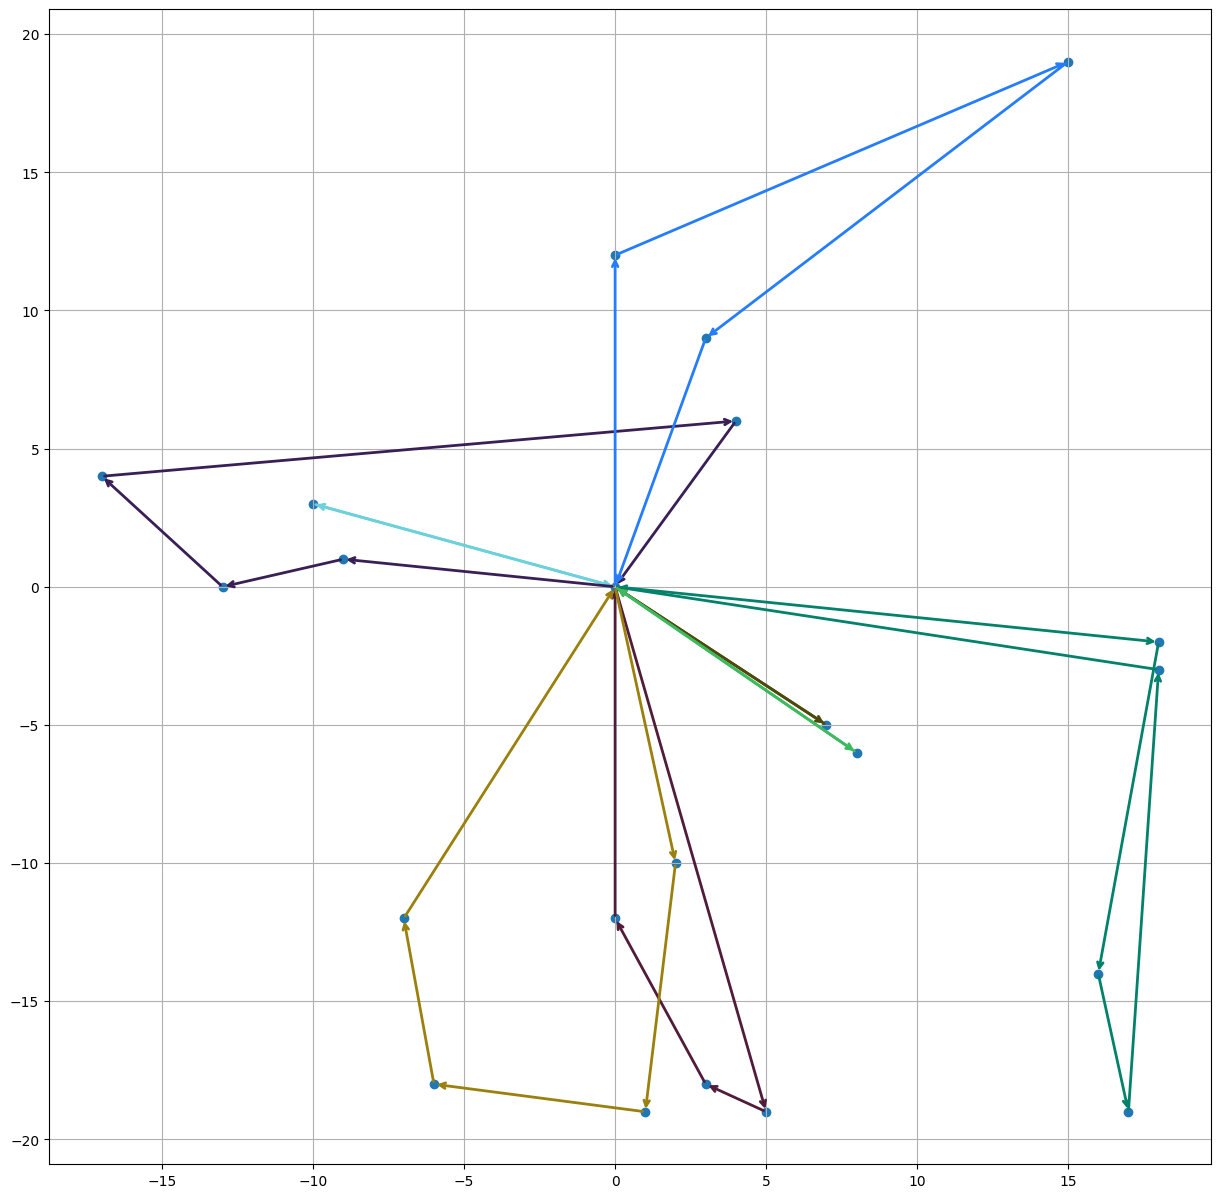

In [18]:
POPULATION_SIZE = 100  # Smaller population for demonstration
GENERATIONS = 100

def genetic_algorithm():

    # Initilization of individuals
    INDIVIDUALS = []
    for i in range(POPULATION_SIZE):
      INDIVIDUALS.append(create_individual(VEHICLES))



    for generation in range(GENERATIONS):
        # Evaluation
        INDIVIDUALS = sorted(INDIVIDUALS, key=fitness, reverse=True)
        if generation % 10 == 0:
            best = INDIVIDUALS[0]
            print(f"Generation {generation}: {visualize_individual(best, fitness(best))} \n\n")

        # Selection
        new_population = []

        # Elitism
        new_population.extend([INDIVIDUALS[0], INDIVIDUALS[1]])

        while len(new_population) < POPULATION_SIZE:
            parent1 = tournament_selection(INDIVIDUALS)
            parent2 = tournament_selection(INDIVIDUALS)

            # Crossover
            # if random.random() < crossover_rate:
            offspring1 = order_crossover(parent1, parent2)
            offspring2 = order_crossover(parent2, parent1)

            # else:
            #     offspring1, offspring2 = parent1, parent2

            # Mutation
            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)


            new_population.extend([offspring1, offspring2])

        INDIVIDUALS = new_population[:POPULATION_SIZE]

    return max(INDIVIDUALS, key=fitness)

final = genetic_algorithm()

print(f"FINAL RESULT: {visualize_individual(final, fitness(final))} \n\n")

graph_map(final)